
# CutMix and MixUp

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Dataset

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
num_classes = ds_info.features["label"].num_classes

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


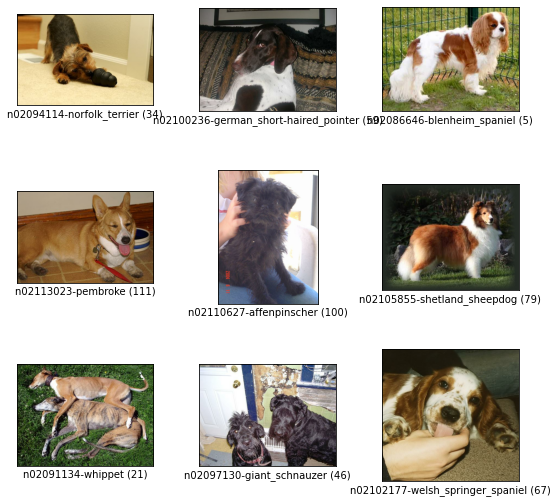

In [3]:
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### Basic Augmentation

In [23]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

### CutMix

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### data augmentation

In [12]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

In [24]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [25]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [26]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## Model

In [16]:
tf.random.set_seed(2020)

### Basic

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [19]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2252 - accuracy: 0.4444WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_test_batch_end` time: 0.0289s). Check your callbacks.


750/750 [==============================] - 143s 190ms/step - loss: 2.2252 - accuracy: 0.4444 - val_loss: 3.6615 - val_accuracy: 0.1750
Epoch 2/20
750/750 [==============================] - 142s 190ms/step - loss: 0.7342 - accuracy: 0.7952 - val_loss: 1.2290 - val_accuracy: 0.6507
Epoch 3/20
750/750 [==============================] - 142s 190ms/step - loss: 0.3086 - accuracy: 0.9270 - val_loss: 1.0230 - val_accuracy: 0.7014
Epoch 4/20
750/750 [==============================] - 142s 190ms/step - loss: 0.1170 - accuracy: 0.9807 - val_loss: 0.9454 - val_accuracy: 0.7298
Epoch 5/20
750/750 [==============================] - 142s 190ms/step - loss: 0.0399 - accuracy: 0.9968 - val_loss: 0.8920 - val_accuracy: 0.7450
Epoch 6/20
750/750 [==============================] - 142s 190ms/step - loss: 0.0161 - accuracy: 0.9993 - val_loss: 0.8968 - val_accuracy: 0.7497
Epoch 7/20
750/750 [==============================] - 143s 190ms/step - loss: 0.0186 - accuracy: 0.9992 - val_loss: 0.9172 - val_accura

### Basic augmetaion

In [28]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [30]:
history_basic_aug_resnet50 = basic_aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:51 - loss: 5.1010 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0581s vs `on_train_batch_end` time: 0.1069s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2660 - accuracy: 0.4271WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0071s vs `on_test_batch_end` time: 0.0396s). Check your callbacks.


750/750 [==============================] - 143s 190ms/step - loss: 2.2660 - accuracy: 0.4271 - val_loss: 2.9460 - val_accuracy: 0.2768
Epoch 2/20
750/750 [==============================] - 142s 190ms/step - loss: 0.9626 - accuracy: 0.7243 - val_loss: 1.2045 - val_accuracy: 0.6456
Epoch 3/20
750/750 [==============================] - 143s 190ms/step - loss: 0.5292 - accuracy: 0.8559 - val_loss: 1.1575 - val_accuracy: 0.6636
Epoch 4/20
750/750 [==============================] - 143s 191ms/step - loss: 0.3113 - accuracy: 0.9203 - val_loss: 1.0064 - val_accuracy: 0.7139
Epoch 5/20
750/750 [==============================] - 143s 190ms/step - loss: 0.1953 - accuracy: 0.9534 - val_loss: 1.0179 - val_accuracy: 0.7169
Epoch 6/20
750/750 [==============================] - 145s 194ms/step - loss: 0.0923 - accuracy: 0.9858 - val_loss: 0.9705 - val_accuracy: 0.7270
Epoch 7/20
750/750 [==============================] - 143s 191ms/step - loss: 0.0690 - accuracy: 0.9897 - val_loss: 0.9814 - val_accura

### CutMix

In [33]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [34]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [35]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:42 - loss: 5.5370 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0660s vs `on_train_batch_end` time: 0.1166s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8278 - accuracy: 0.2153WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_test_batch_end` time: 0.0396s). Check your callbacks.


750/750 [==============================] - 145s 193ms/step - loss: 3.8278 - accuracy: 0.2153 - val_loss: 3.3414 - val_accuracy: 0.1931
Epoch 2/20
750/750 [==============================] - 145s 193ms/step - loss: 2.9527 - accuracy: 0.4204 - val_loss: 1.5659 - val_accuracy: 0.5753
Epoch 3/20
750/750 [==============================] - 145s 193ms/step - loss: 2.6296 - accuracy: 0.5297 - val_loss: 1.2728 - val_accuracy: 0.6542
Epoch 4/20
750/750 [==============================] - 145s 194ms/step - loss: 2.4410 - accuracy: 0.5926 - val_loss: 1.2884 - val_accuracy: 0.6428
Epoch 5/20
750/750 [==============================] - 146s 194ms/step - loss: 2.2803 - accuracy: 0.6370 - val_loss: 1.1151 - val_accuracy: 0.6916
Epoch 6/20
750/750 [==============================] - 145s 193ms/step - loss: 2.1845 - accuracy: 0.6672 - val_loss: 1.2653 - val_accuracy: 0.6649
Epoch 7/20
750/750 [==============================] - 145s 194ms/step - loss: 2.0901 - accuracy: 0.6982 - val_loss: 1.0881 - val_accura

### MixUp

In [42]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [43]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [44]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:49 - loss: 5.0878 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0617s vs `on_train_batch_end` time: 0.1113s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7376 - accuracy: 0.2362WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0073s vs `on_test_batch_end` time: 0.0361s). Check your callbacks.


750/750 [==============================] - 139s 185ms/step - loss: 3.7376 - accuracy: 0.2362 - val_loss: 3.7654 - val_accuracy: 0.1540
Epoch 2/20
750/750 [==============================] - 134s 179ms/step - loss: 2.8755 - accuracy: 0.4790 - val_loss: 1.5660 - val_accuracy: 0.5624
Epoch 3/20
750/750 [==============================] - 133s 178ms/step - loss: 2.5978 - accuracy: 0.5763 - val_loss: 1.4337 - val_accuracy: 0.6004
Epoch 4/20
750/750 [==============================] - 133s 178ms/step - loss: 2.4221 - accuracy: 0.6434 - val_loss: 1.6285 - val_accuracy: 0.5612
Epoch 5/20
750/750 [==============================] - 140s 187ms/step - loss: 2.3074 - accuracy: 0.6997 - val_loss: 1.2306 - val_accuracy: 0.6556
Epoch 6/20
750/750 [==============================] - 139s 185ms/step - loss: 2.1915 - accuracy: 0.7303 - val_loss: 1.3260 - val_accuracy: 0.6398
Epoch 7/20
750/750 [==============================] - 138s 184ms/step - loss: 2.1079 - accuracy: 0.7670 - val_loss: 1.2471 - val_accura

## Result

### Visualization

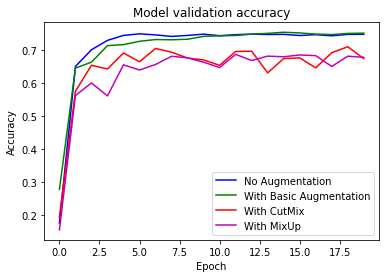

In [45]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()

### Comparison

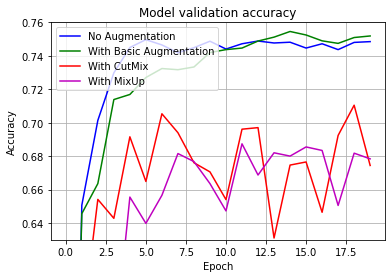

In [47]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.63, 0.76)
plt.show()

## Report

'No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp' 4가지를 비교해보면 augmentation을 하지 않은 데이터와, 기본적인 augmetation을 한 데이터를 이용한 모델이 성능이 더 좋게나왔습니다.  
<br>
'CutMix', 'MixUp'을 적용한 데이터를 이용한 모델의 성능이 더 좋을 것이라고 예상했는데, 다른 결과가 나왔습니다.  
'CutMix', 'MixUp'을 구현한 부분에서 수정이 필요하다고 생각합니다.